<a href="https://colab.research.google.com/github/AtharBagunaid/Face-mask-detector/blob/main/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [2]:
!pwd

/content


In [3]:
cd "/content/drive/MyDrive/Colab Notebooks/DIP/Mask_detection"

/content/drive/MyDrive/Colab Notebooks/DIP/Mask_detection


In [4]:
!pwd

/content/drive/MyDrive/Colab Notebooks/DIP/Mask_detection


## Data preparation

In [5]:
train_path = "/content/drive/MyDrive/Colab Notebooks/DIP/Mask_detection/train"
valid_path = "/content/drive/MyDrive/Colab Notebooks/DIP/Mask_detection/valid"
test_path = "/content/drive/MyDrive/Colab Notebooks/DIP/Mask_detection/test"

In [6]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size = (224,224), classes = ['with_mask', 'without_mask'], batch_size = 100, class_mode = 'categorical')
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size = (224,224), classes = ['with_mask', 'without_mask'], batch_size = 100, class_mode = 'categorical')
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size = (224,224), classes = ['with_mask', 'without_mask'], batch_size = 2234, class_mode = 'categorical')

Found 4694 images belonging to 2 classes.
Found 522 images belonging to 2 classes.
Found 2234 images belonging to 2 classes.


In [7]:
train_image_count = len([f for f in os.listdir(train_path)])
train_image_count

2

In [8]:
def plots(ims, figsize = (23,17), rows = 10, interp = False, titles = None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize = 16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')

In [9]:
imgs, labels = next(train_batches)   

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


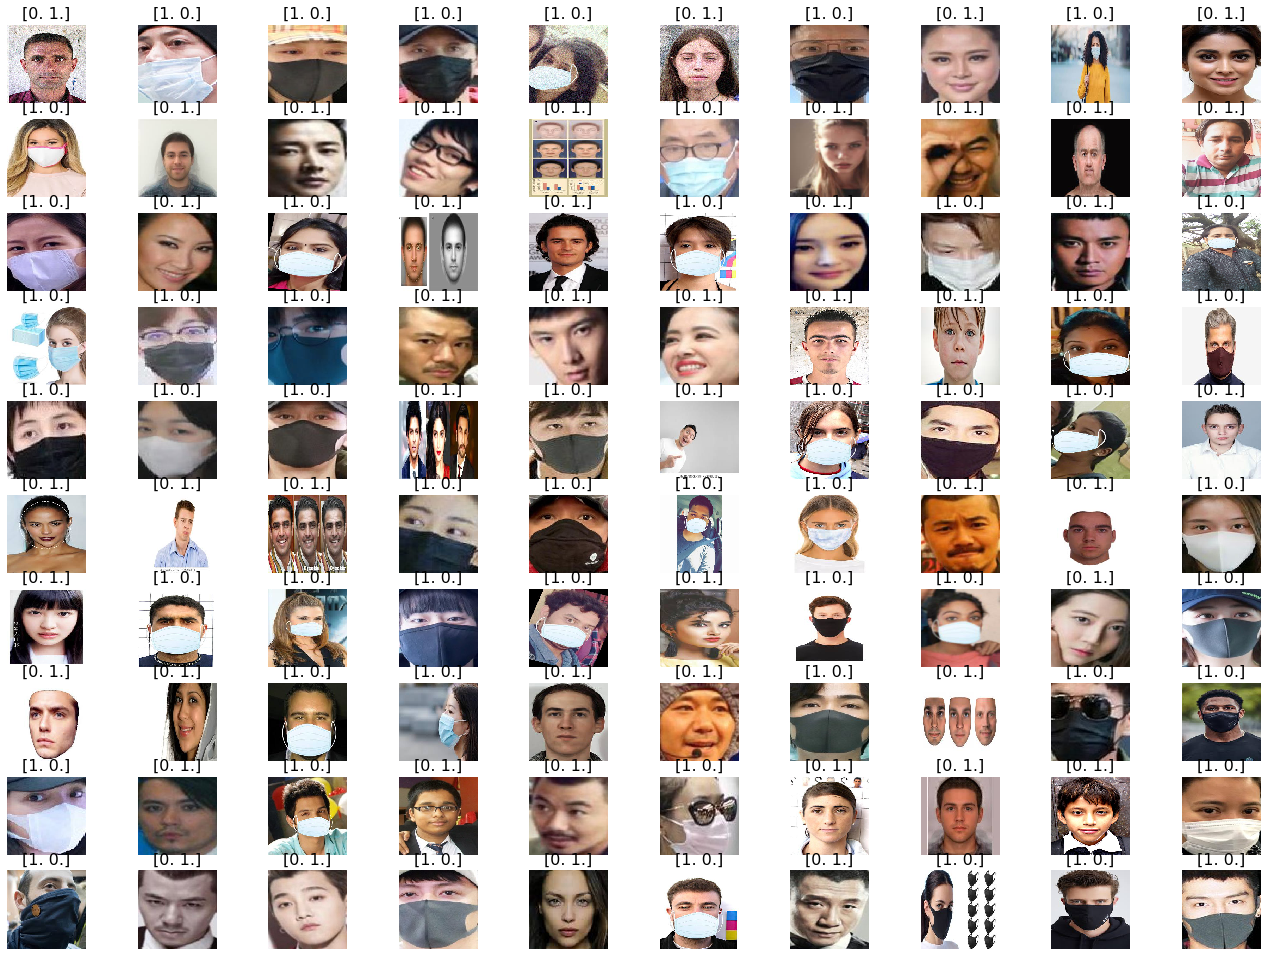

In [10]:
plots(imgs, titles = labels)  

## vgg-16 model preparation

In [11]:
vgg16_model = keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 4s 0us/step


In [12]:
# show the built in model structure
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
# copy all layers of vgg16 into sequential model except the last layer
# then add output layer with 2 classes and softmax as activation function
model = Sequential()
for layer in vgg16_model.layers[:-1]:
  model.add(layer)

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

## Train the model using the train set

In [15]:
# Compile the model
model.compile(Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [16]:
# fitting / training the model
model.fit_generator(train_batches, steps_per_epoch=46, validation_data=valid_batches, validation_steps=5, epochs= 5, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
46/46 [==============================] - 2668s 57s/step - loss: 0.5276 - accuracy: 0.7729 - val_loss: 0.2021 - val_accuracy: 0.9200
Epoch 2/5
46/46 [==============================] - 2534s 55s/step - loss: 0.1299 - accuracy: 0.9494 - val_loss: 0.1513 - val_accuracy: 0.9400
Epoch 3/5
46/46 [==============================] - 2529s 55s/step - loss: 0.0909 - accuracy: 0.9695 - val_loss: 0.1358 - val_accuracy: 0.9480
Epoch 4/5
46/46 [==============================] - 2519s 55s/step - loss: 0.0606 - accuracy: 0.9790 - val_loss: 0.1244 - val_accuracy: 0.9520
Epoch 5/5
46/46 [==============================] - 2524s 55s/step - loss: 0.0528 - accuracy: 0.9824 - val_loss: 0.1253 - val_accuracy: 0.9520


We notice from the above results that the accuracy increased from 0.6 at the first epoch up to 0.9794 in the last epoch

In [17]:
model.save('/content/drive/My Drive/Colab Notebooks/faceMask_detection.h5')
print('saved sucessfully')

saved sucessfully
